In [1]:
import numpy as np
import matplotlib.pyplot as plt
from reactionmodel.model import Species, Reaction, Model

In [2]:
S1 = Species('S1')
S2 = Species('S2')
T  = Species('T')

In [3]:
l = 1.0
u = 1.0001
birth = Reaction('birth', [S1], [(S1, 2)], k=l)
death = Reaction('death', [S1], [], k=u)
m = Model([S1], [birth, death])

In [4]:
from hybrid.hybrid import HybridSimulator, FixedThresholdPartitioner
hybrid_simulator = HybridSimulator(
    k=m.get_k(jit=True)(0),
    N=m.stoichiometry(),
    kinetic_order_matrix=m.kinetic_order(),
    partition_function=FixedThresholdPartitioner(1000).partition_function,
)

hybrid_simulator.simulate(
    (0.0, 1000.0),
    [10.0],
    rng = np.random.default_rng(),

)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Invalid use of none with parameters (float64, array(float64, 1d, C))
No type info available for none as a callable.
During: resolving callee type: none
During: typing of call at /Users/thayer/develop/hybrid/hybrid/hybrid.py (62)


File "../hybrid/hybrid.py", line 62:
        def jit_dydt(t, y_expanded, deterministic_mask, stochastic_mask, hitting_point):
            <source elided>

            propensities = propensity_function(t, y)
            ^


In [4]:
import hybrid.simulate as simulate

result = simulate.simulate(
    (0.0, 100.0),
    np.array([10.0]),
    k = m.get_k(jit=True)(0),
    N = m.stoichiometry(),
    kinetic_order_matrix=m.kinetic_order(),
    rng = np.random.default_rng(),
    method='gillespie')

/Users/thayer/develop/hybrid/hybrid/gillespie.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  hitting_time = hitting_point / total_propensity


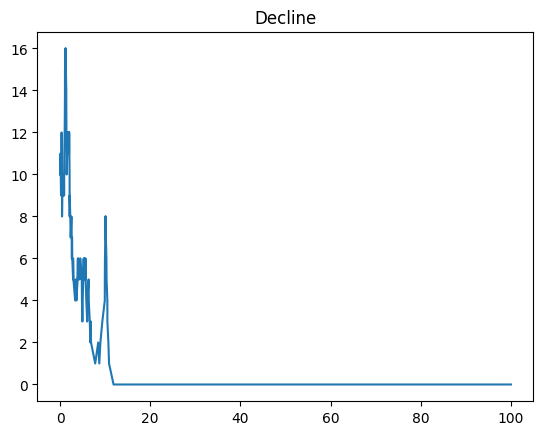

In [6]:
plt.plot(result.t_history, result.y_history[0,:].T)
plt.title("Decline")
plt.show()

In [4]:
skip = True
if not skip:
    result = hybrid.forward_time(
        np.array([10.0]),
        (0.0, 1000.0),
        k = m.get_k(jit=True),
        N = m.stoichiometry(),
        kinetic_order_matrix=m.kinetic_order(),
        rng = np.random.default_rng(),
        partition_function=hybrid.FixedThresholdPartitioner(1000).partition_function,
    )
    print(result)

In [5]:
if not skip:
    result = hybrid.forward_time(
        np.array([10.0]),
        (0.0, 1000.0),
        k = m.get_k(jit=True),
        N = m.stoichiometry(),
        kinetic_order_matrix=m.kinetic_order(),
        rng = np.random.default_rng(),
        partition_function=hybrid.FixedThresholdPartitioner(1000).partition_function,
        t_eval=[1.0]
    )
    print(result)

In [6]:
if not skip:
    plt.plot(result.t_history, result.y_history[0,:].T)
    plt.title("Decline")
    plt.show()

In [7]:
np.mean(np.random.exponential(3, 100000))

3.0111279301505784

# Pure Gillespie

In [8]:
from hybrid.gillespie import forward_time as g_forward_time

In [9]:
result = g_forward_time(
    np.array([10.0]),
    (0.0, 1000.0),
    k = m.get_k(jit=True)(0), # this is gross, I need get_k() to return a matrix when all rates are constant
    N = m.stoichiometry(),
    kinetic_order_matrix=m.kinetic_order(),
    rng = np.random.default_rng(),
    t_eval=[1.0]
)

/Users/thayer/develop/hybrid/hybrid/gillespie.py:87: RuntimeWarning: divide by zero encountered in scalar divide
  hitting_time = hitting_point / total_propensity


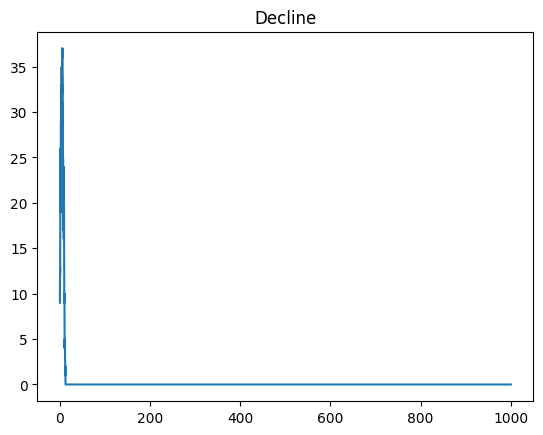

In [10]:
plt.plot(result.t_history, result.y_history[0,:].T)
plt.title("Decline")
plt.show()

In [11]:
result

SimulationResult(t=1000.0, y=array([0.]), t_history=array([4.35211264e-03, 8.72938581e-02, 3.41548751e-01, 3.72834721e-01,
       4.13383404e-01, 4.61452648e-01, 5.83843075e-01, 5.94366188e-01,
       7.66981362e-01, 8.08631359e-01, 8.13107644e-01, 8.16884642e-01,
       8.40382903e-01, 9.44030662e-01, 9.47901533e-01, 9.71802140e-01,
       9.78160212e-01, 9.91756600e-01, 1.03812446e+00, 1.08648228e+00,
       1.14163512e+00, 1.16043445e+00, 1.18627752e+00, 1.19067526e+00,
       1.19363816e+00, 1.19550438e+00, 1.19985078e+00, 1.20276622e+00,
       1.22570773e+00, 1.23703561e+00, 1.24638646e+00, 1.24764547e+00,
       1.25584118e+00, 1.39829479e+00, 1.41184531e+00, 1.42627265e+00,
       1.42637474e+00, 1.43422189e+00, 1.43429803e+00, 1.43448768e+00,
       1.43449434e+00, 1.48114052e+00, 1.49805137e+00, 1.51527804e+00,
       1.52438870e+00, 1.66406916e+00, 1.70238691e+00, 1.74723475e+00,
       1.75012527e+00, 1.76217315e+00, 1.79684889e+00, 1.84024567e+00,
       1.87486569e+00, 1.

In [12]:
ri = 500
np.exp(-1*ri/1000), 1-ri/1000

(0.6065306597126334, 0.5)

In [13]:
# p more than 1 event
1 - (ri/1000 + 1) * np.exp(-1*ri/1000), 0

(0.09020401043104986, 0)

In [14]:
from scipy.stats import poisson

(0.0, 250.0)

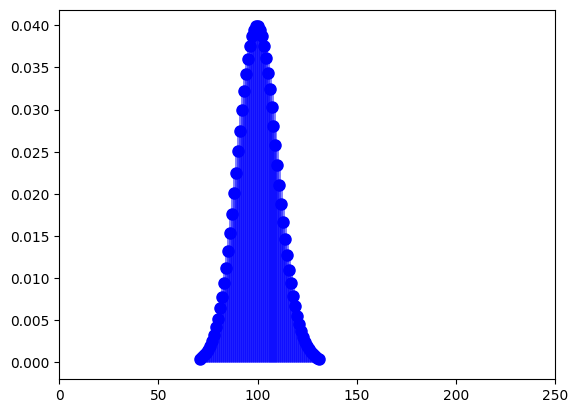

In [15]:
mu = 100

fig, ax = plt.subplots(1, 1)
x = np.arange(poisson.ppf(0.001, mu),
            poisson.ppf(0.999, mu))
ax.plot(x, poisson.pmf(x, mu), 'bo', ms=8, label='poisson pmf')
ax.vlines(x, 0, poisson.pmf(x, mu), colors='b', lw=5, alpha=0.5)
ax.set_xlim([0, 2.5*mu])